In [1]:
import numpy as np

import lunar_lander
from turbo_test import demo_heuristic_lander
import tensorflow as tf
import tensorflow_probability as tfp
import trieste

import timeit

2021-11-09 08:56:32.653611: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-09 08:56:32.653628: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-09 08:56:33.857255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 08:56:33.857594: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-09 08:56:33.857640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

In [2]:
# this space is created by going approximately +-0.2 around parameter values, but not going below 0
# see for original values https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py
# original values are
# 0.5 1 0.4 0.55 0.5 1 0.5 0.5 0 0.5 0.05 0.05
# and for parameter definition https://github.com/uber-research/TuRBO
search_space = trieste.space.Box(
    [0.3, 0.8, 0.2, 0.35, 0.3, 0.8, 0.3, 0.3, 0.0, 0.3, 0.0,  0.0],
    [0.7, 1.2, 0.6, 0.75, 0.7, 1.2, 0.7, 0.7, 0.2, 0.7, 0.25, 0.25]
)

In [3]:
OBJECTIVE = trieste.observer.OBJECTIVE
# lander crashed or timed out
FAILURE = "FAILURE"

create_empty_dataset = lambda : trieste.data.Dataset(
                                    tf.zeros((0, search_space.dimension), tf.float64),
                                    tf.zeros((0, 1), tf.float64)
                                )

def lander_observer(x):
    all_datasets = {
        OBJECTIVE: create_empty_dataset(),
        FAILURE: create_empty_dataset()
    }

    def add_data(dataset_tag, x, y):
        new_dataset = trieste.data.Dataset(np.atleast_2d(x), np.atleast_2d(y))
        all_datasets[dataset_tag] += new_dataset

    for w in x.numpy():
        result = demo_heuristic_lander(lunar_lander.LunarLander(), w)
        if result.timeout or result.has_crashed:
            add_data(FAILURE, w, 0.0)
            continue
        else:
            add_data(FAILURE, w, 1.0)

        normalized_fuel = np.float64(result.total_fuel / 100.0)
        add_data(OBJECTIVE, w, normalized_fuel)
    
    return all_datasets

In [4]:
num_initial_points = 1
initial_query_points = search_space.sample(1)
initial_data = lander_observer(initial_query_points)

# collect points until we have at least one in each dataset
while any(len(initial_data[tag]) < search_space.dimension for tag in initial_data):
    initial_query_points = search_space.sample(1)
    new_initial_data = lander_observer(initial_query_points)
    for tag in initial_data:
        initial_data[tag] = initial_data[tag] + new_initial_data[tag]
    num_initial_points += 1

DemoHeuristicResult: reward: 254.70, fuel: 18.90, steps: 163.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 11.42, fuel: 22.50, steps: 126.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 18.10, fuel: 20.37, steps: 121.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 229.60, fuel: 21.57, steps: 223.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 235.33, fuel: 32.55, steps: 312.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 276.04, fuel: 16.23, steps: 206.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 285.76, fuel: 44.76, steps: 307.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -4.56, fuel: 15.27, steps: 107.0, crashed: True, timeo

In [5]:
print(len(initial_data[OBJECTIVE]))
print(len(initial_data[FAILURE]))

12
37


In [6]:
import gpflow


def create_regression_model(data):
    variance = tf.math.reduce_variance(data.observations)
    kernel = gpflow.kernels.Matern52(variance, lengthscales=[0.2]*int(search_space.dimension))
    scale = tf.constant(1.0, dtype=tf.float64)
    kernel.variance.prior = tfp.distributions.LogNormal(
        tf.constant(-2.0, dtype=tf.float64), scale
    )
    kernel.lengthscales.prior = tfp.distributions.LogNormal(
        tf.math.log(kernel.lengthscales), scale
    )
    gpr = gpflow.models.GPR(data.astuple(), kernel)
    return gpr


def create_classification_model(data):
    kernel = gpflow.kernels.SquaredExponential(
        lengthscales=[0.2]*int(search_space.dimension)
    )
    likelihood = gpflow.likelihoods.Bernoulli()
    vgp = gpflow.models.VGP(data.astuple(), kernel, likelihood)
    return vgp

from trieste.models.gpflow import GPflowModelConfig

classification_model_config_args = {
    "model_args": {"use_natgrads": True},
    "optimizer": tf.optimizers.Adam(1e-3),
    "optimizer_args": {"max_iter": 50},
}
models = {
    OBJECTIVE: GPflowModelConfig(**{
        "model": create_regression_model(initial_data[OBJECTIVE]),
        "optimizer": gpflow.optimizers.Scipy(),
    }),
    FAILURE: GPflowModelConfig(
        create_classification_model(initial_data[FAILURE]),
        **classification_model_config_args
    )
}

In [7]:
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.acquisition import (
    SingleModelAcquisitionBuilder, ExpectedConstrainedImprovement, LocalPenalizationAcquisitionFunction
)

BATCH_SIZE = 10
ITERATIONS = 100

class ProbabilityOfValidity(SingleModelAcquisitionBuilder):
    def prepare_acquisition_function(self, model, dataset=None):
        def acquisition(at):
            mean, _ = model.predict_y(tf.squeeze(at, -2))
            return mean
        return acquisition

pov = ProbabilityOfValidity().using(FAILURE)
eci = ExpectedConstrainedImprovement(
    OBJECTIVE, pov, min_feasibility_probability = 0.0
)
lp = LocalPenalizationAcquisitionFunction(search_space, base_acquisition_function_builder=eci)
rule = EfficientGlobalOptimization(lp, num_query_points=BATCH_SIZE)

In [8]:
bo = trieste.bayesian_optimizer.BayesianOptimizer(lander_observer, search_space)
start = timeit.default_timer()
result = bo.optimize(ITERATIONS, initial_data, models, rule).final_result.unwrap()
stop = timeit.default_timer()

2021-11-09 08:56:35.643336: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-11-09 08:56:36.656955: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


DemoHeuristicResult: reward: 287.95, fuel: 31.35, steps: 233.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 187.05, fuel: 51.24, steps: 392.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 22.71, fuel: 12.96, steps: 81.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 14.95, fuel: 19.17, steps: 123.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 53.50, fuel: 21.09, steps: 151.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -99.55, fuel: 5.76, steps: 90.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -142.48, fuel: 68.31, steps: 369.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -35.03, fuel: 4.53, steps: 56.0, crashed: True, timeout

DemoHeuristicResult: reward: -39.95, fuel: 133.11, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -157.41, fuel: 48.60, steps: 311.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 43.41, fuel: 25.53, steps: 147.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 8.64, fuel: 17.22, steps: 107.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -13.65, fuel: 18.09, steps: 110.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -220.95, fuel: 15.36, steps: 100.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -167.24, fuel: 9.93, steps: 81.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 27.46, fuel: 14.07, steps: 98.0, crashed: True, t

DemoHeuristicResult: reward: 283.32, fuel: 23.91, steps: 207.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -154.63, fuel: 47.25, steps: 270.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 235.90, fuel: 27.39, steps: 247.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 240.79, fuel: 15.36, steps: 199.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 278.08, fuel: 19.62, steps: 190.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 59.46, fuel: 26.58, steps: 148.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 34.80, fuel: 23.61, steps: 161.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 1.80, fuel: 28.65, steps: 172.0, crashed: True, timeou

DemoHeuristicResult: reward: 296.46, fuel: 39.09, steps: 250.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 275.07, fuel: 29.94, steps: 234.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 270.41, fuel: 36.51, steps: 291.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 263.81, fuel: 32.01, steps: 294.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 283.61, fuel: 30.81, steps: 243.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 227.77, fuel: 40.23, steps: 279.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 271.40, fuel: 42.42, steps: 338.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 234.82, fuel: 42.39, steps: 308.0, crashed: False, tim

DemoHeuristicResult: reward: 254.36, fuel: 32.61, steps: 268.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 237.51, fuel: 28.35, steps: 245.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -35.51, fuel: 30.81, steps: 199.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -212.69, fuel: 49.83, steps: 363.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 222.31, fuel: 30.63, steps: 246.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -146.45, fuel: 53.07, steps: 295.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 258.36, fuel: 33.24, steps: 249.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 165.21, fuel: 58.44, steps: 456.0, crashed: Fal

DemoHeuristicResult: reward: 152.21, fuel: 56.31, steps: 596.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 45.05, fuel: 20.52, steps: 111.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -134.13, fuel: 62.13, steps: 356.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -67.58, fuel: 63.24, steps: 389.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 246.65, fuel: 22.02, steps: 199.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 282.22, fuel: 31.32, steps: 257.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 279.61, fuel: 20.97, steps: 230.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 8.83, fuel: 15.00, steps: 105.0, crashed: True, ti

DemoHeuristicResult: reward: 15.21, fuel: 17.19, steps: 124.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -47.60, fuel: 13.41, steps: 90.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 24.62, fuel: 17.73, steps: 129.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 257.37, fuel: 19.62, steps: 236.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 263.56, fuel: 23.70, steps: 281.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 293.63, fuel: 18.90, steps: 199.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 270.65, fuel: 16.53, steps: 181.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -39.87, fuel: 24.54, steps: 136.0, crashed: True, 

DemoHeuristicResult: reward: 280.81, fuel: 16.41, steps: 201.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 243.53, fuel: 17.79, steps: 193.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 237.68, fuel: 16.56, steps: 276.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 244.05, fuel: 16.80, steps: 198.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 252.57, fuel: 15.39, steps: 202.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -98.55, fuel: 28.35, steps: 153.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 289.49, fuel: 20.40, steps: 247.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 264.95, fuel: 14.28, steps: 332.0, crashed: Fal

DemoHeuristicResult: reward: -58.68, fuel: 9.36, steps: 75.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 264.72, fuel: 14.46, steps: 155.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 284.59, fuel: 15.06, steps: 211.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 257.24, fuel: 15.24, steps: 199.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 205.93, fuel: 19.41, steps: 357.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 5.43, fuel: 11.52, steps: 73.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 15.43, fuel: 12.69, steps: 104.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -48.96, fuel: 9.45, steps: 91.0, crashed: True, timeout:

DemoHeuristicResult: reward: 211.49, fuel: 31.08, steps: 280.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 259.05, fuel: 28.17, steps: 366.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 198.92, fuel: 19.80, steps: 235.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -122.57, fuel: 20.79, steps: 134.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 14.12, fuel: 14.10, steps: 95.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -178.80, fuel: 24.72, steps: 127.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -137.51, fuel: 22.08, steps: 123.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 3.82, fuel: 14.10, steps: 95.0, crashed: True,

DemoHeuristicResult: reward: 273.85, fuel: 12.99, steps: 234.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 261.75, fuel: 13.86, steps: 193.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 21.89, fuel: 12.66, steps: 104.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 32.72, fuel: 14.40, steps: 115.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -3.58, fuel: 18.51, steps: 140.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 251.68, fuel: 15.24, steps: 188.0, crashed: False, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 14.33, fuel: 18.03, steps: 116.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 27.20, fuel: 13.05, steps: 94.0, crashed: True, time

DemoHeuristicResult: reward: -100.35, fuel: 14.19, steps: 106.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -22.36, fuel: 12.63, steps: 104.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -68.79, fuel: 5.82, steps: 66.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 35.78, fuel: 16.17, steps: 120.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 243.89, fuel: 18.99, steps: 191.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: -8.29, fuel: 24.96, steps: 154.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 4.75, fuel: 12.81, steps: 100.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -101.63, fuel: 46.62, steps: 400.0, crashed: True, tim

DemoHeuristicResult: reward: -45.85, fuel: 111.63, steps: 1001.0, crashed: False, timeout: True, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -49.14, fuel: 10.47, steps: 85.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -173.63, fuel: 18.00, steps: 135.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 245.77, fuel: 15.90, steps: 164.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 25.41, fuel: 14.76, steps: 97.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 19.81, fuel: 10.83, steps: 68.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 11.95, fuel: 15.36, steps: 99.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 16.32, fuel: 12.48, steps: 95.0, crashed: True, timeout

DemoHeuristicResult: reward: -67.92, fuel: 7.98, steps: 77.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: 12.07, fuel: 13.26, steps: 92.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 6.49, fuel: 12.06, steps: 86.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -16.44, fuel: 15.48, steps: 103.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: -10.29, fuel: 22.02, steps: 128.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 297.68, fuel: 15.63, steps: 221.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 42.61, fuel: 13.56, steps: 76.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 284.50, fuel: 24.24, steps: 468.0, crashed: False, timeout: Fa

DemoHeuristicResult: reward: -208.69, fuel: 18.57, steps: 153.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -138.70, fuel: 18.48, steps: 120.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -148.86, fuel: 26.34, steps: 148.0, crashed: True, timeout: False, is_in_helipad: False, success: False
DemoHeuristicResult: reward: -33.97, fuel: 11.46, steps: 84.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 7.79, fuel: 11.76, steps: 92.0, crashed: True, timeout: False, is_in_helipad: True, success: False
DemoHeuristicResult: reward: 265.84, fuel: 17.70, steps: 159.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 276.73, fuel: 17.10, steps: 153.0, crashed: False, timeout: False, is_in_helipad: True, success: True
DemoHeuristicResult: reward: 6.76, fuel: 18.27, steps: 135.0, crashed: True, time

DemoHeuristicResult: reward: 34.89, fuel: 21.72, steps: 119.0, crashed: True, timeout: False, is_in_helipad: True, success: False
Optimization completed without errors


In [9]:
print(f"Time taken: {stop - start:.0f}s")

Time taken: 3032s


In [10]:
import matplotlib.pyplot as plt
from trieste.acquisition.multi_objective.dominance import non_dominated

# fancy code to import trieste notebook plotting utils
import importlib.util
spec = importlib.util.spec_from_file_location("plotting", "../trieste_stuff/trieste/docs/notebooks/util/plotting.py")
plotting = importlib.util.module_from_spec(spec)
spec.loader.exec_module(plotting)

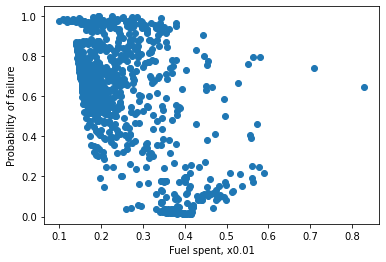

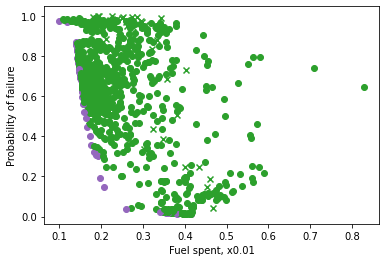

In [11]:
all_query_points = result.datasets[FAILURE].query_points
objective_model_values, _ = result.models[OBJECTIVE].predict(all_query_points)
failure_model_values, _ = result.models[FAILURE].predict_y(all_query_points)

plt.scatter(objective_model_values, 1-failure_model_values)
plt.xlabel("Fuel spent, x0.01")
plt.ylabel("Probability of failure");
plt.show();

points_in_objective_space = tf.concat([objective_model_values, 1-failure_model_values], axis=1)
plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=num_initial_points)
plt.xlabel("Fuel spent, x0.01")
plt.ylabel("Probability of failure");
plt.show();

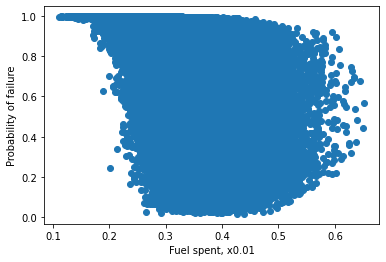

In [12]:
many_random_points = search_space.sample(100000)
objective_model_values, _ = result.models[OBJECTIVE].predict(many_random_points)
failure_model_values, _ = result.models[FAILURE].predict_y(many_random_points)

plt.scatter(objective_model_values, 1-failure_model_values)
plt.xlabel("Fuel spent, x0.01")
plt.ylabel("Probability of failure");
plt.show();

# this fails with OOM because of how non-dominated is implemented in Trieste
# we may want to optimize it for large volumes
# points_in_objective_space = tf.concat([objective_model_values, 1-failure_model_values], axis=1)
# plotting.plot_mobo_points_in_obj_space(points_in_objective_space, num_init=0)
# plt.xlabel("Fuel spent, x0.01")
# plt.ylabel("Probability of failure");
# plt.show();

In [13]:
result.models[OBJECTIVE]._model

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,LogNormal,True,(),float64,0.04096871637044932
GPR.kernel.lengthscales,Parameter,Softplus,LogNormal,True,"(12,)",float64,"[1.86678709, 1.13278338, 0.63201031..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0138387822136884
GPR.data[0],ResourceVariable,,,False,"(None, 12)",float64,"[[0.46057758, 0.82941853, 0.23953237..."
GPR.data[1],ResourceVariable,,,False,"(None, 1)",float64,[[0.189...


In [14]:
result.models[OBJECTIVE]._model.kernel.lengthscales

<Parameter: dtype=float64, shape=[12], fn="softplus", numpy=
array([1.86678709, 1.13278338, 0.63201031, 0.64846572, 0.83748756,
       0.71028449, 0.42651603, 0.68419972, 0.30427041, 1.06031358,
       0.22610152, 0.28933174])>

In [15]:
result.models[FAILURE]._model

name,class,transform,prior,trainable,shape,dtype,value
VGPWrapper.kernel.variance,Parameter,Softplus,,True,(),float64,4.24229950495842
VGPWrapper.kernel.lengthscales,Parameter,Softplus,,True,"(12,)",float64,"[2.12522392, 1.34251784, 0.71625167..."
VGPWrapper.data[0],ResourceVariable,,,False,"(None, 12)",float64,"[[0.46057758, 0.82941853, 0.23953237..."
VGPWrapper.data[1],ResourceVariable,,,False,"(None, 1)",float64,[[1....
VGPWrapper.q_mu,Parameter,Identity,,True,"(1037, 1)",float64,[[-0.7828059...
VGPWrapper.q_sqrt,Parameter,FillTriangular,,True,"(1, 1037, 1037)",float64,"[[[2.63313640e-01, 0.00000000e+00, 0.00000000e+00..."
VGPWrapper._num_data,ResourceVariable,,,False,(),float64,1037.0


In [16]:
result.models[FAILURE]._model.kernel.lengthscales

<Parameter: dtype=float64, shape=[12], fn="softplus", numpy=
array([2.12522392, 1.34251784, 0.71625167, 1.26162166, 0.42913839,
       2.42780442, 0.39652727, 0.35860544, 0.33525177, 1.36099703,
       0.10986209, 0.16099507])>

In [17]:
def probability_of_failure(point, n_tries=100):
    if not isinstance(point, np.ndarray):
        point = point.numpy()

    assert point.shape == (int(search_space.dimension),)

    n_failures = 0
    for _ in range(n_tries):
        result = demo_heuristic_lander(lunar_lander.LunarLander(), point, print_result=False)
        if result.timeout or result.has_crashed:
            n_failures += 1
    
    return n_failures / n_tries

In [18]:
all_query_points = result.datasets[FAILURE].query_points
objective_model_values, _ = result.models[OBJECTIVE].predict(all_query_points)
failure_model_values, _ = result.models[FAILURE].predict_y(all_query_points)

In [19]:
pf_points, _ = non_dominated(tf.concat([objective_model_values, 1-failure_model_values], axis=1))
pf_input_points = []
for pf_point in pf_points:
    pf_input_point = tf.boolean_mask(all_query_points, tf.equal(objective_model_values, pf_point[0])[:,0])
    if len(pf_input_point) > 1:
        pf_input_point = pf_input_point[0:1, :]
    pf_input_points.append(pf_input_point)
pf_input_points = tf.concat(pf_input_points, axis=0)

In [20]:
failure_actual_values = [
    probability_of_failure(p) for p in pf_input_points
]

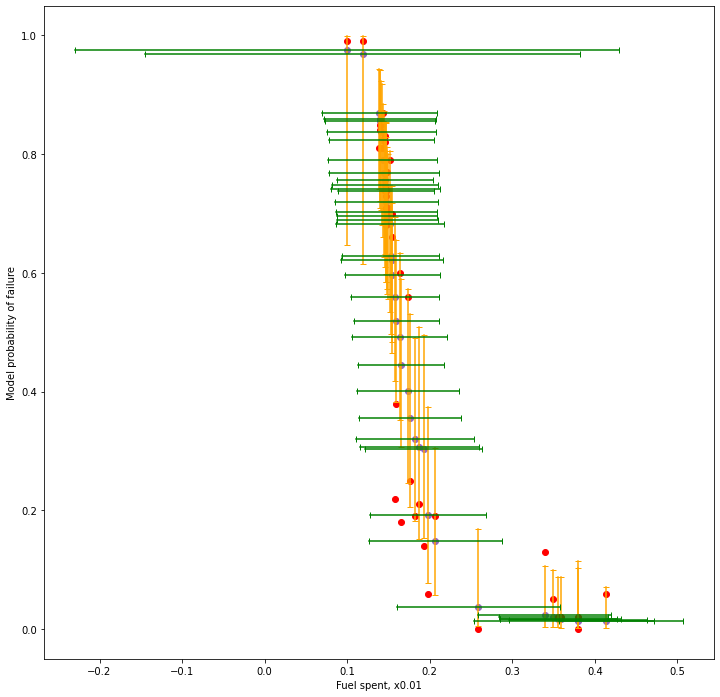

In [21]:
points_in_objective_space = tf.concat([objective_model_values, 1-failure_model_values], axis=1)

mean, variance = result.models[FAILURE].predict(pf_input_points)
failure_lower_conf_bounds, _ = result.models[FAILURE]._model.likelihood.predict_mean_and_var(
    mean - 2 * tf.sqrt(variance), variance)
failure_upper_conf_bounds, _ = result.models[FAILURE]._model.likelihood.predict_mean_and_var(
    mean + 2 * tf.sqrt(variance), variance)

mean, variance = result.models[OBJECTIVE].predict(pf_input_points)
objective_lower_conf_bounds = mean - 2 * tf.sqrt(variance)
objective_upper_conf_bounds = mean + 2 * tf.sqrt(variance)

plotting.plot_mobo_points_in_obj_space(
    points_in_objective_space,
    num_init=num_initial_points,
    only_plot_pareto=True,
    figsize=(12,12)
)
plt.scatter(pf_points[:, 0], failure_actual_values, c='r')

for i, (lower, upper) in enumerate(zip(1-failure_lower_conf_bounds, 1-failure_upper_conf_bounds)):
    plt.plot((pf_points[i].numpy()[0], pf_points[i].numpy()[0]), (lower,upper), '_-',color='orange')

for i, (lower, upper) in enumerate(zip(objective_lower_conf_bounds, objective_upper_conf_bounds)):
    plt.plot((lower,upper), (pf_points[i].numpy()[1], pf_points[i].numpy()[1]), '|-',color='green')


plt.xlabel("Fuel spent, x0.01")
plt.ylabel("Model probability of failure");
plt.show();